# **Visium data example (mouse brain)**

## Packages

In [1]:
import scanpy as sc
import commot as ct

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## **Preprocessing**
Here, **non-negative** values that reasonably reflect the abundancy of molecules are needed. \
We will perform the most basic data preprocessing here with only normalizing total count and log1p transform. \
A more detailed preprocessing could be performed such as regressing out cell cycle genes.

In [3]:
adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata_dis500 = adata.copy()
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

Perform a basic clustering of the data using common methods for scRNA-seq data.
Alternatively, tools dedicated for spatial transcriptomics data could be used.

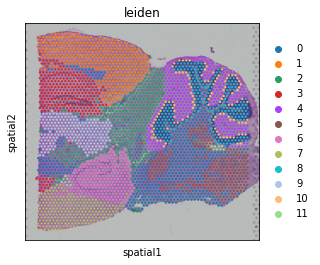

In [4]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.spatial(adata, color='leiden')

## **Spatial communication inference**
Using the CellChatDB ligand-receptor database here. Only the secreted signaling LR pairs will be used.

In [5]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
df_cellchat

,0,1,2,3
0,Tgfb1,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
1,Tgfb2,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
2,Tgfb3,Tgfbr1_Tgfbr2,TGFb,Secreted Signaling
3,Tgfb1,Acvr1b_Tgfbr2,TGFb,Secreted Signaling
4,Tgfb1,Acvr1c_Tgfbr2,TGFb,Secreted Signaling
...,...,...,...,...
1204,Uts2b,Uts2r,UROTENSIN,Secreted Signaling
1205,Uts2b,Sstr5,UROTENSIN,Secreted Signaling
1206,Bag6,Ncr3-ps,BAG,Secreted Signaling
1207,Lgals9,Havcr2,GALECTIN,Secreted Signaling


filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.

In [6]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.3)
df_cellchat_filtered

,0,1,2,3
0,Fgf1,Fgfr1,FGF,Secreted Signaling
1,Fgf1,Fgfr2,FGF,Secreted Signaling
2,Fgf1,Fgfr3,FGF,Secreted Signaling
3,Vegfa,Flt1,VEGF,Secreted Signaling
4,Vegfb,Flt1,VEGF,Secreted Signaling
5,Igf2,Igf1r,IGF,Secreted Signaling
6,Mdk,Sdc2,MK,Secreted Signaling
7,Mdk,Sdc4,MK,Secreted Signaling
8,Mdk,Ptprz1,MK,Secreted Signaling
9,Mdk,Lrp1,MK,Secreted Signaling


Now perform spatial communication inference for these 250 ligand-receptor pairs with a spatial distance limit of 500. CellChat database considers heteromeric units. The signaling results are stored as spot-by-spot matrices in the obsp slots. For example, the score for spot i signaling to spot j through the LR pair can be retrieved from `adata_dis500.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]`.

In [7]:
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
adata_dis500

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'commot-cellchat-info'
    obsm: 'spatial', 'commot-cellchat-sum-sender', 'commot-cellchat-sum-receiver'
    obsp: 'commot-cellchat-Ptn-Sdc4', 'commot-cellchat-Ptn-Ptprz1', 'commot-cellchat-Ptn-Sdc2', 'commot-cellchat-Ptn-Sdc3', 'commot-cellchat-Ptn-Ncl', 'commot-cellchat-Mdk-Sdc4', 'commot-cellchat-Mdk-Ptprz1', 'commot-cellchat-Mdk-Lrp1', 'commot-cellchat-Mdk-Sdc2', 'commot-cellchat-Mdk-Ncl', 'commot-cellchat-Vegfa-Flt1', 'commot-cellchat-Psap-Gpr37l1', 'commot-cellchat-Psap-Gpr37', 'commot-cellchat-Vegfb-Flt1', 'commot-cellchat-Igf2-Igf1r', 'commot-cellchat-Grn-Sort1', 'commot-cellchat-Kitl-Kit', 'commot-cellchat-Penk-Oprl1', 'commot-cellchat-Gas6-Axl', 'commot-cellchat-Gas6-Tyro3', 'commot-cellchat-Fgf1-Fgfr2', 'commot-cellchat-Fgf1-Fgfr1', 'commot-cellchat-Fgf1-Fgfr3', 'commot-cellchat-FGF', 'commot-cellchat-GAS

Determine the spatial direction of a signaling pathway, for example, the PSAP pathway. The interpolated signaling directions for where the signals are sent by the spots and where the signals received by the spots are from are stored in `adata_dis500.obsm['commot_sender_vf-cellchat-PSAP']` and `adata_dis500.obsm['commot_receiver_vf-cellchat-PSAP']`, respectively.

<AxesSubplot:>

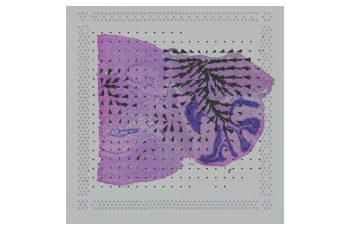

In [8]:
ct.tl.communication_direction(adata_dis500, database_name='cellchat', pathway_name='PSAP', k=5)
ct.pl.plot_cell_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

Or summarize the signaling to the leiden clustering and visualize the significant ones as networks with automatic node embedding. We did this also for the PSAP signaling pathway and the results are stored in `adata_dis500.uns['commot_cluster-leiden-cellchat-PSAP']`.

In [9]:
adata_dis500.obs['leiden'] = adata.obs['leiden']
ct.tl.cluster_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', clustering='leiden', n_permutations=100)

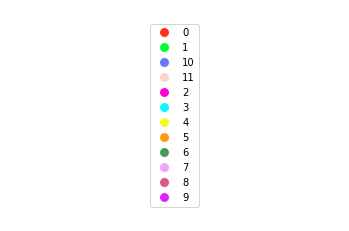

In [10]:
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'],
    nx_node_pos=None, nx_bg_pos=False, p_value_cutoff = 5e-2, filename='PSAP_cluster.pdf', nx_node_cmap='Light24')

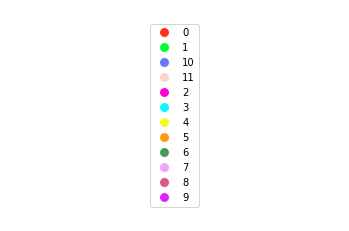

In [11]:
import numpy as np
ct.tl.cluster_position(adata_dis500, clustering='leiden')
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'], clustering='leiden',
    nx_node_pos='cluster', nx_pos_idx=np.array([0, 1]), nx_bg_pos=True, nx_bg_ndsize=0.25, p_value_cutoff=5e-2,
    filename='PSAP_cluster_spatial.pdf', nx_node_cmap='Light24')